<a href="https://colab.research.google.com/github/alexcontarino/personal-projects/blob/main/NFL_Projects/Historic_Pythagorean_Expectation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project examines NFL game results since 1999 to estimate a value $c$ for the Pythagorean Expectation formula:

$$ \text{Pythagorean Wins} = \frac{\text{Points Scored}^c}{\text{Points Scored}^c + \text{Points Allowed}^c}$$

While the value for $c$ for the NFL quoted in the article below is 2.37, that number is based on game outcomes from 1998 to 2004. The results from the notebook below examines data from 1999 to the most recent 2024 season. This data suggest that over this time frame **the best value $c$ for Pythagorean expectation in the NFL:**
- **Has been steadily increasing for the past 20 years.**
- **Is now closer to 2.8.**

An increasing value $c$ means that results are more certain given some constant point differential. This could track with the trend in play in recent years, in which offenses have emphasized ball control, potentially leading to fewer possessions and a slight decrease in scoring (evidence forth coming but I have a pretty good hunch from looking at data that this is true).

Using game data from the `nfl_data_py` package (link below), I backtrack to find an overall optimal $c$. This value is 2.664. I then break down the results season-by-season to find this $c$ value increasing steadily since the start of the data and is now closer to 2.8.

Does Vegas share this estimate? A market-implied Pythagorean expectation project will be shared soon to investigate.

https://en.wikipedia.org/wiki/Pythagorean_expectation

https://pypi.org/project/nfl-data-py/

In [1]:
%pip install nfl_data_py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import nfl_data_py as nfl

# Data Processing

In [2]:
game_data = nfl.import_schedules(range(1999,2025))

In [3]:
game_data.shape

(6991, 46)

In [4]:
data = game_data.loc[game_data.game_type == "REG"]
data = data[["game_id", "season", "week", "away_team", "away_score", "home_team", "home_score"]]
data["home_wins"] = 0
data.loc[data.home_score > data.away_score, "home_wins"] = 1
data.loc[data.home_score == data.away_score, "home_wins"] = 0.5
data["away_wins"] = 1 - data["home_wins"]

In [5]:
away = data.groupby(["season", "away_team"])[["away_score", "home_score", "away_wins"]].sum()
away = away.rename(columns={'away_team': 'team', 'away_score': 'Points_Scored', 'home_score': 'Points_Allowed', 'away_wins': 'wins'})

home = data.groupby(["season", "home_team"])[["home_score", "away_score", "home_wins"]].sum()
home = home.rename(columns={'home_team': 'team', 'away_score': 'Points_Allowed', 'home_score': 'Points_Scored', 'home_wins': 'wins'})

game_results = home + away

In [6]:
game_results["games_played"] = 16
game_results.loc[game_results.index.get_level_values('season') >= 2021, "games_played"] = 17
game_results["Average_W_Prob"] = game_results["wins"] / game_results["games_played"]

# Data Exploration

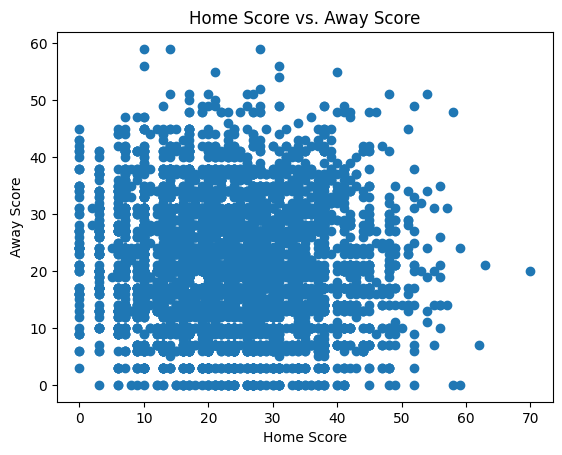

In [7]:
plt.scatter(data.home_score, data.away_score)
plt.xlabel("Home Score")
plt.ylabel("Away Score")
plt.title("Home Score vs. Away Score")
plt.show()

In [8]:
Y = data.away_score
X = data.home_score
X = sm.add_constant(X) # Add a constant for the intercept

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             away_score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.618
Date:                Fri, 18 Jul 2025   Prob (F-statistic):            0.00580
Time:                        00:38:31   Log-Likelihood:                -24954.
No. Observations:                6695   AIC:                         4.991e+04
Df Residuals:                    6693   BIC:                         4.993e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6848      0.303     71.565      0.0

In [9]:
data["total"] = data.home_score + data.away_score
data.total.std()

14.144120768002955

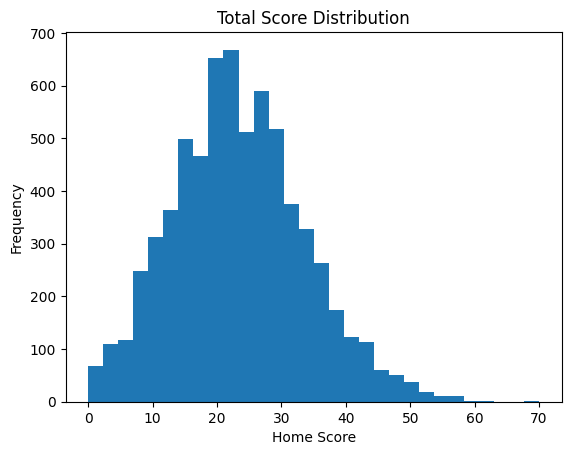

In [10]:
plt.hist(data.home_score, bins=30)
plt.xlabel("Home Score")
plt.ylabel("Frequency")
plt.title("Total Score Distribution")
plt.show()

In [11]:
data.home_score.std()

10.283996176631641

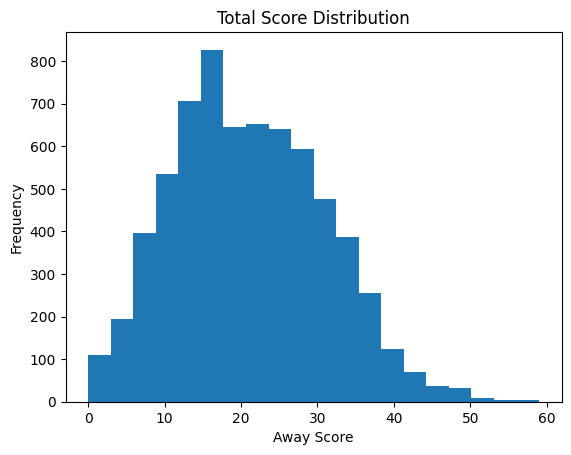

In [12]:
plt.hist(data.away_score, bins=20)
plt.xlabel("Away Score")
plt.ylabel("Frequency")
plt.title("Total Score Distribution")
plt.show()

In [13]:
data.away_score.std()

10.06353113707424

In [14]:
data.total.std() / np.sqrt(2)

10.001403708976367

# Define Functions

In [15]:
def PythW(scored, allowed, c):

  # Pythagorean expectation function

  return (scored**c) / ((scored**c) + (allowed**c))

In [16]:
def SSE(Y, P):

  # sum of squared errors function

  return np.sum((Y - P)**2)

In [17]:
def ema(values, alpha=0.1, x_0=None):

  #exponential moving average function

  if x_0:
    ema_values = [x_0]
  else:
    ema_values = [values[0]]

  for value in values[1:]:
    ema_values.append(alpha * value + (1 - alpha) * ema_values[-1])

  return ema_values

The function below is a silly little algorithm to find a suitable value for $c$ in the Pythagorean Expectation equation. Taking advantage of the 1-d search space and the convexity of the cost function (sum of squared errors), it executes increasingly finer grid searches to arrive at a value for $c$ at user-given level of precision.

The "errors" of sum of squared errors being minimized are the differences between each team's projected win total from the betting lines and the expected number of wins from the Pythagorean expectation using projected points scored, points allowed, and a value $c$.

In [18]:
def find_c(team_outcomes_df, grid_start, grid_stop, grid_density, grid_cut, precision):

  # simple grid search. refine grid each generation by reducing grid length by specified grid_cut. stop after certain precision is reached.
  # determine iterations to reach requested precision
  log_base = 1 / grid_cut
  iterations = math.ceil(math.log((grid_stop - grid_start) / precision, log_base)) + 1

  #print(f"Iterations to Complete: {iterations}")

  min_SSE = np.inf   # initialize variables
  best_c = np.inf
  Y = team_outcomes_df["wins"].to_numpy()   # grab T actual

  for iter in range(iterations):
    # create grid
    grid = np.linspace(grid_start, grid_stop, grid_density)
    grid_length = grid_stop - grid_start

    # evaluate each c in grid
    for c in grid:
      P_c = PythW(team_outcomes_df["Points_Scored"], team_outcomes_df["Points_Allowed"], c)
      team_outcomes_df["Pyth_W"] = team_outcomes_df["games_played"] * P_c
      SSE_c = SSE(Y, team_outcomes_df["Pyth_W"])
      if SSE_c < min_SSE:
        min_SSE = SSE_c
        best_c = c

    # set up next iter
    grid_start = best_c - (grid_length * grid_cut / 2)
    grid_stop = best_c + (grid_length * grid_cut / 2)

    #print(f"Iteration {iter+1} Complete! Best c value: {best_c}. SSE: {min_SSE}")

  return best_c

# Full Results

In [19]:
c = find_c(game_results, 0, 5, 100, 0.5, 1e-6)
print(f"Best c value: {round(c,3)}")

Best c value: 2.664


In [20]:
game_results["Pyth_W_Prob"] = PythW(game_results["Points_Scored"], game_results["Points_Allowed"], c)
game_results["Pyth_W"] = game_results["games_played"] * game_results["Pyth_W_Prob"]

In [21]:
SSE_Pyth = SSE(game_results["wins"], game_results["Pyth_W"])
print(f"Sum of Squared Errors: {round(SSE_Pyth,3)}")

Sum of Squared Errors: 1377.753


In [22]:
RMSE = np.sqrt(SSE_Pyth / len(game_results))
print(f"Root Mean Squared Error: {round(RMSE,3)}")

Root Mean Squared Error: 1.289


In [28]:
SST = sum((game_results["wins"] - game_results["wins"].mean())**2)
R_squared = (SST - SSE_Pyth) / SST
print(f"R-squared: {round(R_squared,3)}")

R-squared: 0.826


# Season-By-Season Analysis

In [24]:
season_c_list = []

for season in range(1999,2025):
  season_results = game_results.loc[game_results.index.get_level_values('season') == season,:]
  season_c = find_c(season_results, 0, 5, 100, 0.5, 1e-6)
  season_c_list.append(season_c)

/tmp/ipython-input-18-2958263887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_outcomes_df["Pyth_W"] = team_outcomes_df["games_played"] * P_c


In [25]:
x_values = range(1999,2025)
window = 5

moving_average = np.convolve(season_c_list, np.ones(window)/window, mode='valid')
while len(moving_average) < len(x_values):
  moving_average = [np.nan] + list(moving_average)

In [26]:
c_ema = ema(season_c_list, 0.2)
while len(c_ema) < len(x_values):
  c_ema = [np.nan] + list(c_ema)

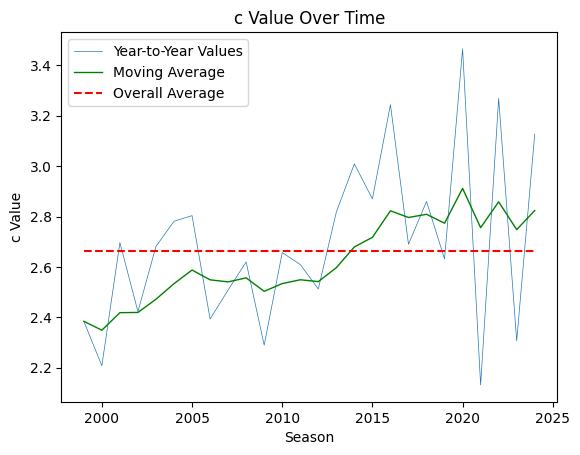

In [27]:
plt.plot(x_values, season_c_list, label="Year-to-Year Values", linewidth=0.5)
plt.plot(x_values, c_ema, color="green", label="Moving Average", linewidth=1)
plt.plot(x_values, c * np.ones(len(x_values)), color="red", label="Overall Average", linestyle="--")

plt.xlabel("Season")
plt.ylabel("c Value")
plt.title("c Value Over Time")
plt.legend()

plt.show()